# [NSF's OIR Lab](https://nationalastro.org/) Astro Data Archive: How to make an exposure map for a survey


Knut Olsen, [Community Science and Data Center](https://nationalastro.org/programs/csdc/)

### Table Of Contents:
* [Goals & notebook summary](#goals)
* [Imports and setup](#init)
* [Details](#details)
* [Where do we look for the fields that we need?](#hdu_search)
* [Doing the search](#search)
* [Combining results](#combine)
* [Computing $t_{\rm eff}$](#teff)
* [Making the depth map](#depth)
* [Resources and references](#doc)



<a class="anchor" id="goals"></a>
# Goals
Use the Advanced Search API to make an exposure map for a survey.  We'll use the Dark Energy Survey DES) as an example.

# Notebook Summary
We show you how to use the API to search the Archive for relevant information from individual r-band HDUs as well as the primary HDUs.  We'll combine information on FWHM, transparency, and sky background to compute maps of effective exposure time, following the procedure adopted by DES.

<a class="anchor" id="init"></a>

# Imports and setup

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import requests
import json
import healpy as hp
from pprint import pprint as pp  # pretty print

print(f'Using Python version: {sys.version}\n')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

This Jupyter Notebook uses (some of) these packages:

pandas==0.23.4
matplotlib==3.0.2
ipython==7.2.0
jupyter==1.0.0
requests==2.22.0
astropy==3.2.1



In [2]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

adsurl = f'{natroot}/api/adv_search'
adsurl

'https://astroarchive.noao.edu/api/adv_search'

## Details <a id="details"/>


The effective exposure time ratio is defined by Nielsen et al. (2016) in their equation 2:

$\tau$ = $\eta^2 ({\rm FWHM}/0.9")^{-2}(b/b_{\rm dark})^{-1}$

where $\eta$ is the atmospheric transparency, FWHM is the full width of the PSF, $b$ is the sky brightness, and $b_{\rm dark}$ is the fiducial dark sky background. The effective exposure time, which accounts for the factors that influence the depth of an exposure, is then:

$t_{\rm eff} = \tau \times t_{\rm exp}$

In order to make a depth map of a survey, we will use the Advanced Search API to get the terms of this equation for individual HDUs.  We will make a Healpix map that counts $t_{\rm eff}$ in the healpixels on the sky overlapping with those HDUs.  Our goal is to be able to adjust e.g. density maps of sources on the sky for differences in depth across a survey.


## Where do we look for the fields that we need? <a id="hdu_search" />  
Some of the fields that we need, in particular the locations of the HDU corners, the FWHM of the PSF, and the sky level, are written into individual HDU headers by the DECam Community Pipeline.  So, we'll look at the fields in the aux_hdu_fields service for decam instcal-processed frames:

In [3]:
requests.get(f'{adsurl}/aux_hdu_fields/decam/instcal/').json()

{'AMPBAL': 'str',
 'AMPSECA': 'str',
 'AMPSECB': 'str',
 'ARAWGAIN': 'str',
 'AVSIG': 'str',
 'AVSKY': 'str',
 'BIASFIL': 'str',
 'BLDINTRP': 'str',
 'BPM': 'str',
 'BPMFIL': 'str',
 'CATALOG': 'str',
 'CCDNUM': 'str',
 'CCDSECA': 'str',
 'CCDSECB': 'str',
 'CD1_1': 'str',
 'CD1_2': 'str',
 'CD2_1': 'str',
 'CD2_2': 'str',
 'CENDEC1': 'str',
 'CENRA1': 'str',
 'COR1DEC1': 'str',
 'COR1RA1': 'str',
 'COR2DEC1': 'str',
 'COR2RA1': 'str',
 'COR3DEC1': 'str',
 'COR3RA1': 'str',
 'COR4DEC1': 'str',
 'COR4RA1': 'str',
 'CROSSRA0': 'str',
 'CRPIX1': 'str',
 'CRPIX2': 'str',
 'CRVAL1': 'str',
 'CRVAL2': 'str',
 'CTYPE1': 'str',
 'CTYPE2': 'str',
 'CUNIT1': 'str',
 'CUNIT2': 'str',
 'D0034494': 'str',
 'D0034496': 'str',
 'D0034497': 'str',
 'DATASEC': 'str',
 'DATASECA': 'str',
 'DATASECB': 'str',
 'DATE': 'str',
 'DEC': 'str',
 'DEC1': 'str',
 'DEC13A_2': 'str',
 'DEC13B_2': 'str',
 'DEC14A_2': 'str',
 'DEC15A_2': 'str',
 'DEC15B_2': 'str',
 'DEC16A_2': 'str',
 'DEC16B_2': 'str',
 'DEC17A_2':

Going through all of the fields requires some digging, but through experimentation we decide that we need these fields:

* COR[1-4]RA1
* COR[1-4]DEC1
* FWHM
* AVSKY

However, we're still missing information on transparency.  Keywords related to transparency (e.g. AIRMASS) are generally written into the primary HDU for the full file, so we'll look at the AUX fields available in the full file search service:

In [4]:
requests.get(f'{adsurl}/aux_file_fields/decam/instcal/').json()

{'AIRMASS': 'str',
 'AOS': 'str',
 'ASTIG1': 'str',
 'ASTIG2': 'str',
 'ATTNUM': 'str',
 'AVSIG': 'str',
 'AVSKY': 'str',
 'AZ': 'str',
 'BAND': 'str',
 'BCAM': 'str',
 'BCAMAX': 'str',
 'BCAMAY': 'str',
 'BCAMAZ': 'str',
 'BCAMDX': 'str',
 'BCAMDY': 'str',
 'BFCFIL': 'str',
 'BUNIT': 'str',
 'CAMSHUT': 'str',
 'CAMSYM': 'str',
 'CCDBIN1': 'str',
 'CCDBIN2': 'str',
 'CCDSEC': 'str',
 'CCDSECA': 'str',
 'CCDSECB': 'str',
 'CENTDEC': 'str',
 'CENTRA': 'str',
 'CONSTVER': 'str',
 'CORN1DEC': 'str',
 'CORN1RA': 'str',
 'CORN2DEC': 'str',
 'CORN2RA': 'str',
 'CORN3DEC': 'str',
 'CORN3RA': 'str',
 'CORN4DEC': 'str',
 'CORN4RA': 'str',
 'CORNDEC1': 'str',
 'CORNDEC2': 'str',
 'CORNDEC3': 'str',
 'CORNDEC4': 'str',
 'CORNRA1': 'str',
 'CORNRA2': 'str',
 'CORNRA3': 'str',
 'CORNRA4': 'str',
 'CROSSRA0': 'str',
 'DARKTIME': 'str',
 'DATASEC': 'str',
 'DATASECA': 'str',
 'DATASECB': 'str',
 'DATE': 'str',
 'DATE-OBS': 'str',
 'DEC': 'str',
 'DES_EXT': 'str',
 'DESNCRAY': 'str',
 'DESNSTRK': 'str'

Again with some digging and experimentation, we'd like to pull out:
* G-TRANSP (transparency as measured by the guider)
* AIRMASS (to check that transparency correlates with airmass, as it should on clear nights)

Since we're going to use information from two database tables, we'll also need a way to join them.  The unique file identifier MD5SUM (called "fitsfile" in the AUX HDU service) will let us do that.


## Doing the search <a id="search" />
So let's issue our searches to the services.  Following the examples in the Advanced Search notebook, we'll start by getting the transparency information from the full file service.  We constraint the search by specifying the instrument, proc_type, prod_type, obs_type, proposal, and filter:

In [5]:
%%time
jj = {
    "outfields" : [
        "md5sum",
        "AIRMASS",
        "G-TRANSP",
    ],
    "search" : [
        ["instrument", "decam"],
        ["proc_type", "instcal"],
        ["prod_type", "image"],
        ["obs_type", "object"],
        ["proposal", "2012B-0001"],
        ["ifilter", "r DECam", "contains"]
    ]
}
dff = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=500000'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    dff = pd.read_json(json.dumps(response.json()))
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use
dff

CPU times: user 563 ms, sys: 89.6 ms, total: 652 ms
Wall time: 9.27 s


,md5sum,url,AIRMASS,G-TRANSP
0,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623
1,0000fc9005a915bb920050031362b4c7,https://astroarchive.noao.edu/api/retrieve/000...,1.19,0.596
2,0001139ab020755d5636ce92c967b7f5,https://astroarchive.noao.edu/api/retrieve/000...,1.05,0.612
3,00019b09c69a4d52490d696efa419186,https://astroarchive.noao.edu/api/retrieve/000...,1.17,0.565
4,0001b9e2e01f57334a7e97b696b1a70b,https://astroarchive.noao.edu/api/retrieve/000...,1.30,0.566
...,...,...,...,...
53598,fffd4327788a4e8d1faaf4baa8579d5e,https://astroarchive.noao.edu/api/retrieve/fff...,1.05,0.723
53599,fffe10362ccfbe3d0d008bc3e311640a,https://astroarchive.noao.edu/api/retrieve/fff...,1.28,0.588
53600,fffe68ac1b0d69740eac177e34558ef9,https://astroarchive.noao.edu/api/retrieve/fff...,1.34,0.730
53601,fffef236aaac15bd2df3db565372115a,https://astroarchive.noao.edu/api/retrieve/fff...,1.37,0.634


Now we'll get the information needed from the individual HDUs.  This will take longer, because the number of HDUs is nearly two orders of magnitude larger than the number of full files.

In [8]:
%%time
jj = {
    "outfields" : [
        "fitsfile",
        "hdu_idx",
        "fitsfile__archive_filename",
        "fitsfile__exposure",
        "fitsfile__ifilter",
        "CENRA1",
        "CENDEC1",
        "COR1RA1",
        "COR2RA1",
        "COR3RA1",
        "COR4RA1",
        "COR1DEC1",
        "COR2DEC1",
        "COR3DEC1",
        "COR4DEC1",
        "FWHM",
        "AVSKY",
    ],
    "search" : [
        ["fitsfile__instrument", "decam"],
        ["fitsfile__proc_type", "instcal"],
        ["fitsfile__prod_type", "image"],
        ["fitsfile__obs_type", "object"],
        ["fitsfile__proposal", "2012B-0001"],
        ["fitsfile__ifilter", "r DECam", "contains"]
    ]
}
df2 = None # Pandas DataFrame
apiurl=f'{adsurl}/hasearch/?limit=5000000'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df2 = pd.read_json(json.dumps(response.json()))
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use
df2

CPU times: user 1min 45s, sys: 22.3 s, total: 2min 7s
Wall time: 8min 58s


,fitsfile,hdu_idx,fitsfile__archive_filename,fitsfile__exposure,fitsfile__ifilter,CENRA1,CENDEC1,COR1RA1,COR2RA1,COR3RA1,COR4RA1,COR1DEC1,COR2DEC1,COR3DEC1,COR4DEC1,FWHM,AVSKY
0,dffae0991f039449d81bef5f8f3dac8e,1,/net/archive/pipe/20161103/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,31.93051,-58.93998,31.64012,31.64154,32.21821,32.22227,-58.86642,-59.01535,-58.86397,-59.01304,3.701069,272.9793
1,002b67612309519f1a09010bce3be610,59,/net/archive/pipe/20160825/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.304001,385.9729
2,002b67612309519f1a09010bce3be610,58,/net/archive/pipe/20160825/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.143698,386.4550
3,002b67612309519f1a09010bce3be610,57,/net/archive/pipe/20160825/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.471498,386.0891
4,dffae0991f039449d81bef5f8f3dac8e,4,/net/archive/pipe/20161103/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,31.63119,-59.10475,31.33988,31.33977,31.92119,31.92397,-59.03053,-59.17957,-59.02948,-59.17853,3.727470,273.0042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228599,6172a37ec85de37489f15ecf2298cb6c,60,/net/archive/pipe/20180218/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,78.53218,-37.40332,78.34386,78.34425,78.71982,78.72087,-37.32956,-37.47848,-37.32784,-37.47691,3.449517,183.9335
3228600,6172a37ec85de37489f15ecf2298cb6c,47,/net/archive/pipe/20180218/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,78.33504,-36.91177,78.14758,78.14781,78.52196,78.52276,-36.83740,-36.98693,-36.83630,-36.98578,3.448630,183.7014
3228601,6172a37ec85de37489f15ecf2298cb6c,52,/net/archive/pipe/20180218/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,78.14104,-37.07626,77.95346,77.95335,78.32857,78.32896,-37.00154,-37.15082,-37.00132,-37.15059,3.384663,183.5129
3228602,6172a37ec85de37489f15ecf2298cb6c,46,/net/archive/pipe/20180218/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,77.94612,-36.91199,77.75912,77.75866,78.13351,78.13360,-36.83679,-36.98626,-36.83735,-36.98687,3.371863,183.9364


## Combining results <a id="combine" />
We can join the two dataframes by using the MD5SUM/fitsfile columns:

In [9]:
dfm = pd.merge(dff,df2,left_on='md5sum',right_on='fitsfile')

In [10]:
dfm

,md5sum,url,AIRMASS,G-TRANSP,fitsfile,hdu_idx,fitsfile__archive_filename,fitsfile__exposure,fitsfile__ifilter,CENRA1,...,COR1RA1,COR2RA1,COR3RA1,COR4RA1,COR1DEC1,COR2DEC1,COR3DEC1,COR4DEC1,FWHM,AVSKY
0,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623,000020ffd7daf44f09119e710b2db7c2,59,/net/archive/pipe/20161220/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,12.89980,...,12.57252,12.57370,13.22437,13.22871,-62.70479,-62.85372,-62.70168,-62.85075,4.079088,247.9758
1,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623,000020ffd7daf44f09119e710b2db7c2,58,/net/archive/pipe/20161220/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,11.54218,...,11.21820,11.21302,11.87004,11.86800,-62.70076,-62.84983,-62.70460,-62.85353,4.204477,248.2630
2,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623,000020ffd7daf44f09119e710b2db7c2,57,/net/archive/pipe/20161220/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,13.23379,...,12.90757,12.91042,13.55549,13.56148,-62.53953,-62.68858,-62.53454,-62.68365,4.023896,248.1203
3,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623,000020ffd7daf44f09119e710b2db7c2,56,/net/archive/pipe/20161220/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,12.55899,...,12.23378,12.23374,12.88283,12.88565,-62.54126,-62.69030,-62.53957,-62.68862,3.936773,248.0356
4,000020ffd7daf44f09119e710b2db7c2,https://astroarchive.noao.edu/api/retrieve/000...,1.24,0.623,000020ffd7daf44f09119e710b2db7c2,55,/net/archive/pipe/20161220/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,11.88310,...,11.55963,11.55642,12.20866,12.20831,-62.53910,-62.68814,-62.54109,-62.69013,4.013863,248.2841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228599,ffffa9e5866da55e05c28fd037fe9a19,https://astroarchive.noao.edu/api/retrieve/fff...,1.10,0.777,ffffa9e5866da55e05c28fd037fe9a19,4,/net/archive/pipe/20131212/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.866211,276.5421
3228600,ffffa9e5866da55e05c28fd037fe9a19,https://astroarchive.noao.edu/api/retrieve/fff...,1.10,0.777,ffffa9e5866da55e05c28fd037fe9a19,3,/net/archive/pipe/20131212/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.820274,278.0053
3228601,ffffa9e5866da55e05c28fd037fe9a19,https://astroarchive.noao.edu/api/retrieve/fff...,1.10,0.777,ffffa9e5866da55e05c28fd037fe9a19,2,/net/archive/pipe/20131212/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.910638,278.3614
3228602,ffffa9e5866da55e05c28fd037fe9a19,https://astroarchive.noao.edu/api/retrieve/fff...,1.10,0.777,ffffa9e5866da55e05c28fd037fe9a19,1,/net/archive/pipe/20131212/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.015250,275.3116


## Computing $t_{\rm eff}$ <a id="teff" />
First, we'll want to eliminate rows that have missing information.  Then we'll compute $\tau$:

In [11]:
dfmc = dfm.dropna()

In [12]:
len(dfmc),len(dfm)

(1347316, 3228604)

In [13]:
apix = 0.263 # arcsec/pixel
sky = dfmc['AVSKY']/dfmc['fitsfile__exposure'] # sky rate
tau = dfmc['G-TRANSP']**2/(dfmc['FWHM']*apix/0.9)**2/(sky/3.)

Text(0.5, 0, 'tau')

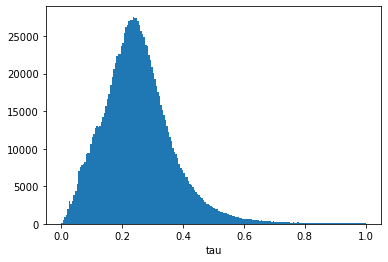

In [14]:
a = plt.hist(tau,bins=200,range=(0,1))
plt.xlabel('tau')

In [15]:
tau_trim = np.clip(tau,0,1) # tau should be between 0 and 1

## Making the depth map <a id="depth" />
Now that we have the needed quantities, we can begin to make our depth map.  Our procedure will be to create a Healpix map, use the coordinates of the HDU corners to identify which healpixels are spanned by each HDU, and add the value of $\tau$ for those HDUs to the appropriate Healpixels.  A couple of notes:

* Because the corners of the HDUs aren't guaranteed to go clockwise, or counter-clockwise, around the HDU, we might not be defining convex polygons when we do the healpixel mapping.  We'll need to order the corners so that they go in one direction, and don't jump an HDU along its diagonal
* We'll need to loop over all of the HDUs one at a time, which can be slow.  Parallel processing might help here.


In [16]:
#functions to order the vertices of HDU corners in counter-clockwise direction, so that their polygon is convex
# reference: https://algorithmtutor.com/Computational-Geometry/Area-of-a-polygon-given-a-set-of-points/
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'
    
def distance(p1, p2):
    d = np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    return d
    
def average_point_inside(points):
    x = 0
    y = 0
    for point in points:
        x += point.x
        y += point.y
    return Point(x / len(points), y / len(points))

def angle(p1, p2):
    k = (p2.y - p1.y) / distance(p1, p2)

    x2 = p2.x
    x1 = p1.x

    if k >= 0:
        if x2 >= x1: # First Quadrant
            return (2.0 * math.pi - math.asin(k))
        else: # Second Quadrant
            return (math.pi + math.asin(k))
    else:
        if x2 >= x1: # Fourth Quadrant
            return math.asin(-k)
        else: # Third Quadrant
            return (math.pi - math.asin(-k))
        
def sort_angular(points, reference_point):
    return sorted(points, key = lambda point: -angle(point, reference_point))

def sort_radec(ra,dec):
    points = [Point(ra[0],dec[0]), Point(ra[1],dec[1]), Point(ra[2],dec[2]), Point(ra[3],dec[3])]
    reference_point = average_point_inside(points)
    spoints =  sort_angular(points, reference_point)
    ra1s=[]
    dec1s=[]
    for p in spoints:
        ra1s.append(p.x)
        dec1s.append(p.y)
    return np.array(ra1s),np.array(dec1s)

#### Pull out the HDU corners

In [17]:
%%time
ratab = [np.array([row[0],row[1],row[2],row[3]]) for row in dfmc[['COR1RA1','COR2RA1','COR3RA1','COR4RA1']].values]
dectab = [np.array([row[0],row[1],row[2],row[3]]) for row in dfmc[['COR1DEC1','COR2DEC1','COR3DEC1','COR4DEC1']].values]

CPU times: user 9.35 s, sys: 924 ms, total: 10.3 s
Wall time: 10.4 s


#### Sort the HDU corners in counter-clockwise direction

In [18]:
%%time
radectab_s = [sort_radec(ra1,dec1) for ra1,dec1 in zip(ratab,dectab)]
vectab = [hp.ang2vec(ra1,dec1,lonlat=True) for ra1, dec1 in radectab_s]

CPU times: user 1min 27s, sys: 1.31 s, total: 1min 28s
Wall time: 1min 29s


#### Define the Healpix map

In [19]:
nside = 4096
print('Resolution is {:5.2f} arcmin'.format(hp.nside2resol(nside,arcmin=True)))
map = np.zeros(hp.nside2npix(nside)) # raw exposure map
tmap = map.copy() # teff map

Resolution is  0.86 arcmin


#### Loop over HDUs (slow!)

In [21]:
%%time
for vec,exptime,tau1 in zip(vectab,dfmc['fitsfile__exposure'],tau_trim):
    try:
        ipix = hp.query_polygon(nside,vec)
        map[ipix] += exptime
        tmap[ipix] += tau1 * exptime
    except:
        pass

CPU times: user 1h 38min 19s, sys: 18.5 s, total: 1h 38min 37s
Wall time: 1h 39min 15s


#### Show the map

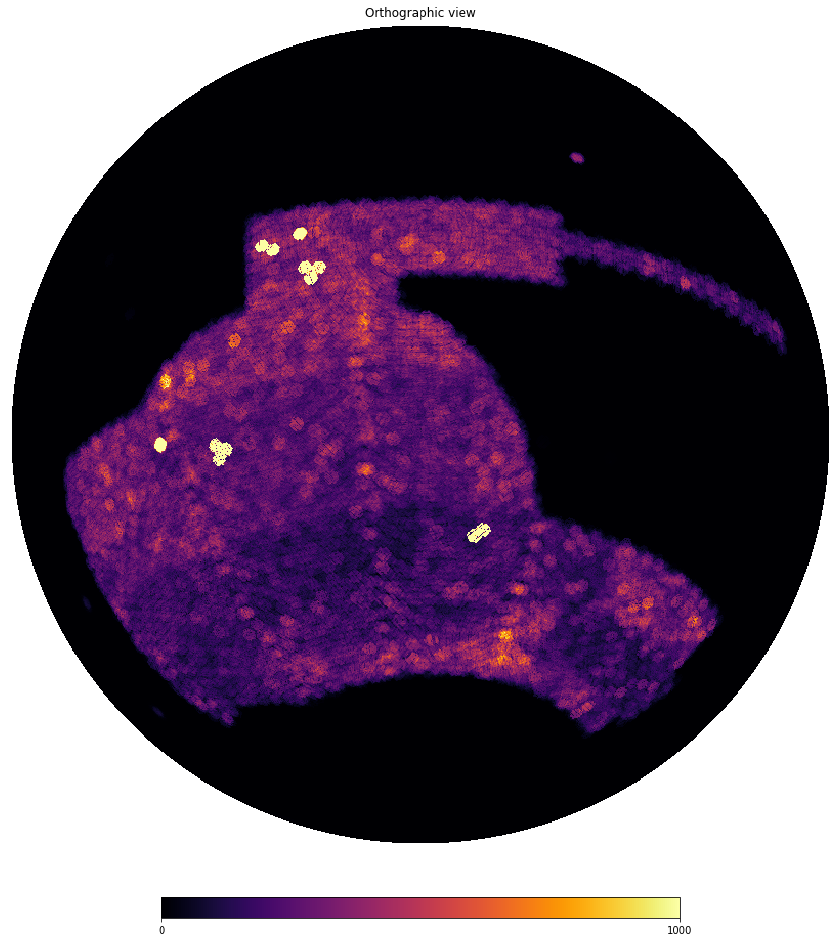

In [22]:
fig = plt.figure(figsize=(15,15))
hp.orthview(tmap,rot=(20,-30),fig=1,cmap='inferno',half_sky=True,min=0,max=1000)

#### Zooming in

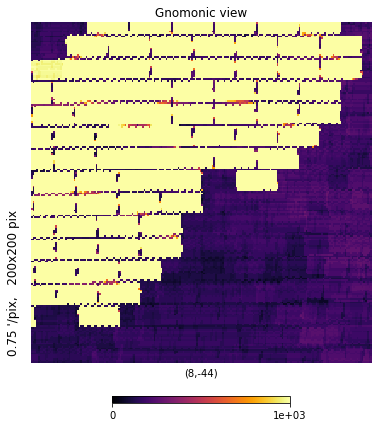

In [23]:
hp.gnomview(tmap,reso=0.75,cmap='inferno',rot=(8,-44),min=0,max=1000)

## Resources and references <a id="docs" />
* Advanced Search [notebook](https://github.com/NOAO/nat-nb)
* Nielsen, E. et al., 2016, [FERMILAB-TM-2610-AE-CD](https://www.osti.gov/biblio/1250877-limiting-magnitude-teff-image-quality-des-year)
* https://algorithmtutor.com/Computational-Geometry/Area-of-a-polygon-given-a-set-of-points/